## 1. IMPORT

In [26]:
# packages
!pip install tsfresh
!pip install xgboost

    100% |████████████████████████████████| 1.2MB 952kB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 1.5MB/s ta 0:00:01
    100% |████████████████████████████████| 522kB 2.1MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 6.8MB/s eta 0:00:01
    100% |████████████████████████████████| 409kB 2.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /Users/kozodoi/Library/Caches/pip/wheels/c2/50/7c/0d83b4baac4f63ff7a765bd16390d2ab43c93587fac9d6017a
  Running setup.py bdist_wheel for ipaddress ... done
  Stored in directory: /Users/kozodoi/Library/Caches/pip/wheels/d7/6b/69/666188e8101897abb2e115d408d139a372bdf6bfa7abb5aef5
Successfully built future ipaddress
  Found existing installation: dask 0.16.1
    Uninstalling dask-0.16.1:
      Successfully uninstalled dask-0.16.1
  Found existing installation: distributed 1.20.2
    Uninstalling distributed-1.20.2:
      Successfully uninstalled distributed-1.20.2


In [785]:
# packages
import numpy as np
import pandas as pd
import xgboost as xgb
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [175]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [759]:
# import data
known   = pd.read_csv("../data/data_agg.csv")
unknown = pd.read_csv("../data/eval_correct.csv")

## 2. PREPARING DATA

In [699]:
# extracting one TS
ts = known[["Month", "demand"]][(known.SalOrg == "97LK") & (known.Material == "00lqzT")]
ts = ts.sort_values(by = "Month").reset_index(drop = True)
ts.tail(3)

In [539]:
# automatic feature extraction
#ts["id"] = np.ones(ts.shape[0])
#ts = extract_features(ts, column_id = "id", column_sort = "Month")
#impute(ts)
#extracted_features = extracted_features.dropna(axis = 1)

In [540]:
# check the dimensions
#ts.shape

In [702]:
# manual feature creation function
def prepare_data(data, lag_start = 3, lag_end = 12):
    
    # create year and month
    data["year"] = data.Month.str[:4]
    data["month"] = data.Month.str[5:]

    # create seasons
    conditions = [
        (data['month'] == "12") | (data['month'] == "01") | (data['month'] == "02"),
        (data['month'] == "03") | (data['month'] == "04") | (data['month'] == "05"),
        (data['month'] == "06") | (data['month'] == "07") | (data['month'] == "08"),
        (data['month'] == "09") | (data['month'] == "10") | (data['month'] == "11")]
    choices = ['winter', 'spring', 'summer', 'fall']
    data['season'] = np.select(conditions, choices)
    
    # drop irrelevant features
    data = data.drop("Month", axis = 1)    

    # create lags
    for i in range(lag_start, lag_end + 1):
        data["lag_{}".format(i)] = data.demand.shift(i)
        
    # convert strings
    le = LabelEncoder()
    data.season = le.fit_transform(data.season)
    data.year   = data.year.astype("int")
    data.month  = data.month.astype("int")
    
    # drop missings
    data = data.dropna(axis = 0)

    # return data
    return data

In [703]:
# creating features
ts = prepare_data(ts)
ts.head(3)

,demand,year,month,season,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
12,1,2013,1,3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0
13,1,2013,2,3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
14,0,2013,3,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## 3. MOVING AVERAGE

In [282]:
# calculation function
def moving_average(series, n):
    return np.average(series[-n:])

In [283]:
# plotting function
def plotMovingAverage(series, n, ci = True):

    # computing moving average
    rolling_mean = series.rolling(window = n).mean()
    
    # calculations for CIs
    if ci == True:
        rolling_std = series.rolling(window = n).std()
        upper_bond = rolling_mean + 1.96*rolling_std
        lower_bond = rolling_mean - 1.96*rolling_std

    # creating the plot
    plt.figure(figsize = (15,5))
    plt.title("Moving Average\n (window size = {})".format(n))
    plt.plot(rolling_mean, "g", label = "Rolling mean trend")
    
    # confidence intervals
    if ci == True:
        plt.plot(upper_bond, "r--", label = "Confidence Interval")
        plt.plot(lower_bond, "r--", label = "")
        
    # legend
    plt.plot(series[n:], label = "Actual values")
    plt.legend(loc = "upper left")
    plt.grid(True)

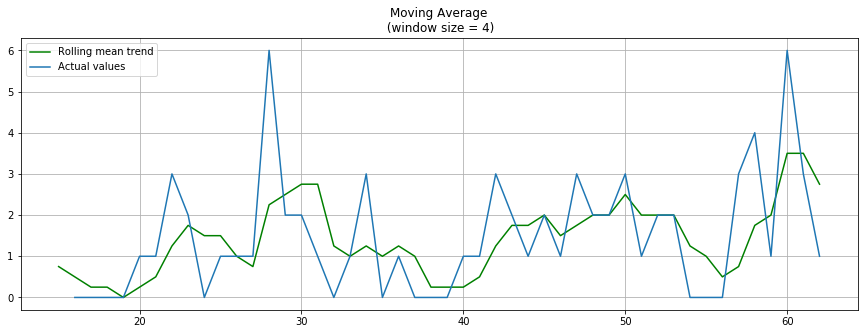

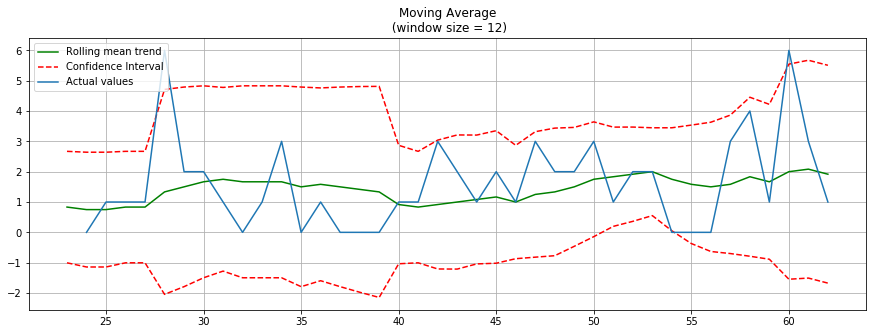

In [284]:
# creating plots
plotMovingAverage(ts.demand, 4, ci = False)
plotMovingAverage(ts.demand, 12)

In [694]:
# cross-validation function
def ts_cv(data, test_size = 3, min_train_size = 10, target = "demand", model = "mov_average", ma = 3):
    
    # error vector
    errors = []
    
    # looping through the folds
    for i in range(0, int(len(ts) - min_train_size - test_size)):
        
        # data partitioning
        id_train = int(min_train_size + i)
        id_valid = int(id_train + test_size)
        train, test = ts[0:id_train], ts[id_train:id_valid]
        
        # separating X and Y
        X_train, X_test = train.drop(target, axis = 1), test.drop(target, axis = 1)
        y_train, y_test = train[target], test[target]
        
        ### training: moving average
        if model == "mov_average":
            pred = [moving_average(y_train, ma)] * test_size
        
        ### training: random forest
        if model == "ran_forest":
            model = RandomForestRegressor()
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
        
        ### training: xgboost
        if model == "xgboost":
            dtrain = xgb.DMatrix(X_train, y_train)
            dtest  = xgb.DMatrix(X_test, y_test)
            params = {
               "objective": "reg:linear",
               "max_depth": 3,
               "silent": 1,
               "eta": 1}
            num_rounds = 50
            model = xgb.train(params, dtrain, num_rounds)
            pred = model.predict(dtest)
            
        # computing errors
        real = np.array(y_test)
        error = abs((pred - real)/len(real)).mean()
        errors.append(error)

    # return error values
    return np.mean(errors)

In [695]:
# testing the function
error = ts_cv(ts, test_size = 3, min_train_size = 3, ma = 3, target = "demand", model = "mov_average")
error

0.4082304526748971

In [732]:
# error vector
errors = []

# looping through the countries
for country in known.SalOrg.unique():
        
    # extracting data
    ts = known[["Month", "demand"]][(known.SalOrg == country) & (known.Material == "00lqzT")]
    ts = ts.sort_values(by = "Month").reset_index(drop = True)
    ts = prepare_data(ts)
    
    # performing CV
    error = ts_cv(ts, test_size = 3, min_train_size = 3, ma = 3, target = "demand", model = "mov_average")
    
    # saving the error
    errors.append(error)
    
# print the errors
errors

[0.4082304526748971, 0.5786008230452674, 0.1530864197530864, 0.0]